In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import networkx as nx
import folium

from utils.downloads import (
    Censo,
    Nivel,
    download_malha,
)

# Perímetros intercensitários (PICs) pelas geometrias

## Explicação inicial e demonstração

A ideia é reproduzir a proposta abaixo, utilizando apenas a interseção entre os setores como fonte para o grafo.

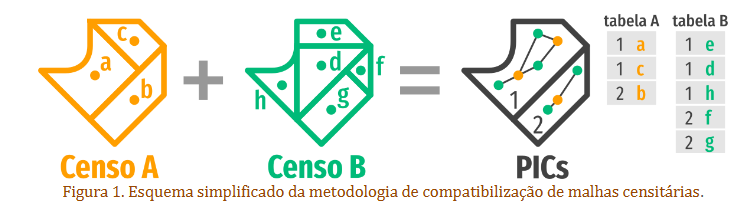

Para demonstrar o algoritmo, vamos utilizar um conjunto de geometrias de exemplo.

In [2]:
# Create geometries for set A
poly_a1 = Polygon([(0, 0), (2, 0), (2, 2), (0, 2)])
poly_a2 = Polygon([(2, 0), (4, 0), (4, 2), (2, 2)])
poly_a3 = Polygon([(4, 0), (6, 0), (6, 2), (4, 2)])
poly_a4 = Polygon([(0, 2), (6, 2), (6, 4), (0, 4)])

# Create geometries for set B
poly_b1 = Polygon([(0, 0), (3, 0), (3, 2), (0, 2)])
poly_b2 = Polygon([(3, 0), (6, 0), (6, 2), (3, 2)])
poly_b3 = Polygon([(0, 2), (3, 2), (3, 4), (0, 4)])
poly_b4 = Polygon([(3, 2), (6, 2), (6, 4), (3, 4)])

# Create GeoDataFrames
gdf_a = gpd.GeoDataFrame({'geometry': [poly_a1, poly_a2, poly_a3, poly_a4], 'id': [f'A{i}' for i in range(1,5)]})
gdf_b = gpd.GeoDataFrame({'geometry': [poly_b1, poly_b2, poly_b3, poly_b4], 'id': [f'B{i}' for i in range(1,5)]})

<Axes: >

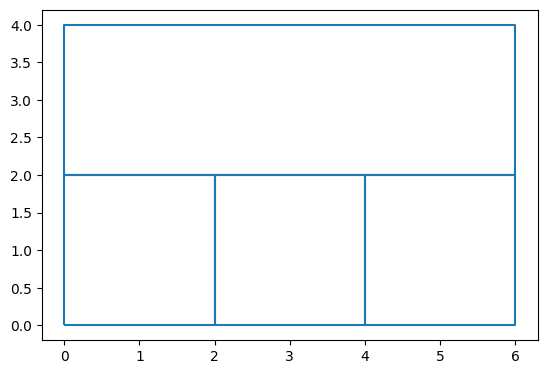

In [3]:
gdf_a.boundary.plot()

<Axes: >

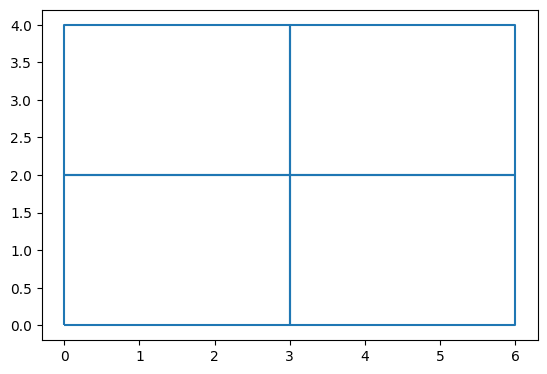

In [4]:
gdf_b.boundary.plot()

Nesse caso, o resultado desejado é um conjunto de dois retângulos, um de (0,0) a (6,2), e outro de (0,2) a (6,4).

Primeiro, precisamos encontrar as interseções entre as geometrias dos dataframes diferentes.

In [5]:
intersections = gpd.overlay(gdf_a, gdf_b, how='intersection', keep_geom_type=True)
intersections = intersections.reset_index()
intersections

index id_1 id_2                                           geometry
0      0   A1   B1  POLYGON ((0.00000 0.00000, 0.00000 2.00000, 2....
1      1   A2   B1  POLYGON ((2.00000 0.00000, 2.00000 2.00000, 3....
2      2   A2   B2  POLYGON ((3.00000 0.00000, 3.00000 2.00000, 4....
3      3   A3   B2  POLYGON ((4.00000 0.00000, 4.00000 2.00000, 6....
4      4   A4   B3  POLYGON ((0.00000 2.00000, 0.00000 4.00000, 3....
5      5   A4   B4  POLYGON ((3.00000 2.00000, 3.00000 4.00000, 6....

<Axes: >

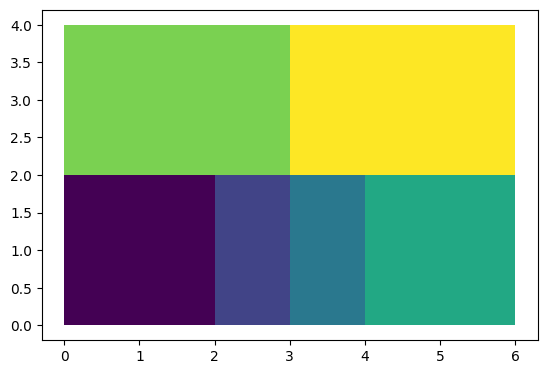

In [6]:
intersections.plot(column='index')

Agora, utilizamos as interseções encontradas para gerar os grafos de relação.

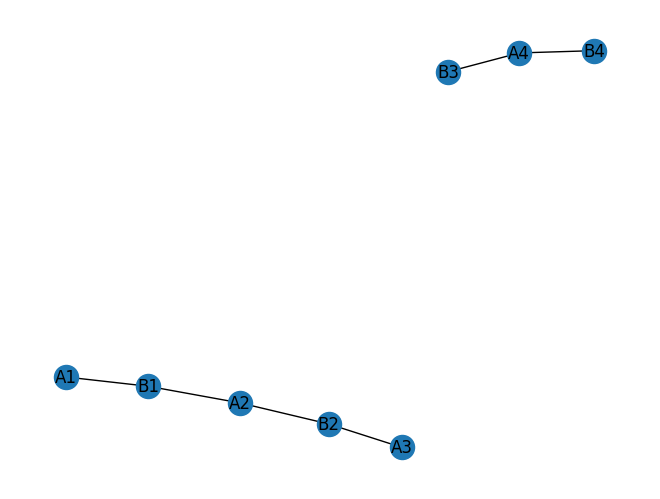

In [7]:
# Generate graph from the DataFrame
G = nx.from_pandas_edgelist(intersections[['id_1', 'id_2']], 'id_1', 'id_2')
nx.draw(G, with_labels=True)

Então, utilizamos os conjuntos de nós conectados para criar um novo dataframe.

In [8]:
connected_components = list(nx.connected_components(G))
rl_df = pd.DataFrame({'set': connected_components})
rl_df

set
0  {A2, A3, A1, B2, B1}
1          {B3, A4, B4}

Para simplificar, vamos utilizar uma coluna de identificador numérico baseada no index.

In [9]:
rl_df = rl_df.reset_index()
rl_df['index'] = rl_df['index'] + 1
rl_df = rl_df.rename(columns={'index': 'pics'})
rl_df

pics                   set
0     1  {A2, A3, A1, B2, B1}
1     2          {B3, A4, B4}

Por último, vamos gerar um registro para cada item do conjunto de nós, de modo que este dataset se torna uma tabela associativa entre geometrias iniciais e "PICs".

In [10]:
rl_df = rl_df.explode('set')
rl_df = rl_df.rename(columns={'set':'item'})
rl_df

pics item
0     1   A2
0     1   A3
0     1   A1
0     1   B2
0     1   B1
1     2   B3
1     2   A4
1     2   B4

Finalmente, agregamos o identificador do PIC no dataframe de interseções.

In [11]:
intersections = intersections.merge(rl_df, how='left', left_on='id_1', right_on='item')
intersections

index id_1 id_2                                           geometry  pics  \
0      0   A1   B1  POLYGON ((0.00000 0.00000, 0.00000 2.00000, 2....     1   
1      1   A2   B1  POLYGON ((2.00000 0.00000, 2.00000 2.00000, 3....     1   
2      2   A2   B2  POLYGON ((3.00000 0.00000, 3.00000 2.00000, 4....     1   
3      3   A3   B2  POLYGON ((4.00000 0.00000, 4.00000 2.00000, 6....     1   
4      4   A4   B3  POLYGON ((0.00000 2.00000, 0.00000 4.00000, 3....     2   
5      5   A4   B4  POLYGON ((3.00000 2.00000, 3.00000 4.00000, 6....     2   

  item  
0   A1  
1   A2  
2   A2  
3   A3  
4   A4  
5   A4

<Axes: >

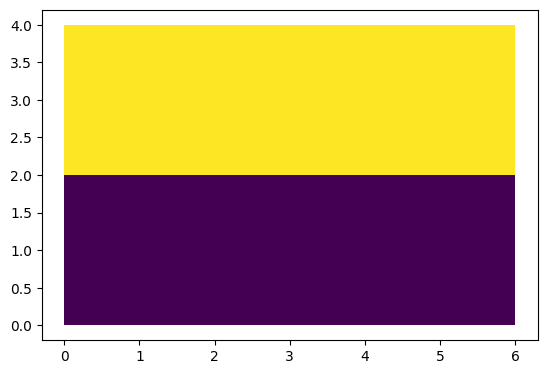

In [12]:
intersections.plot(column='pics')

E geramos um dataset final, apenas com o identificador dos PICs e as respectivas geometrias.

In [13]:
final_gdf = intersections[['pics', 'geometry']].dissolve('pics')
final_gdf = final_gdf.reset_index()
final_gdf

pics                                           geometry
0     1  POLYGON ((2.00000 2.00000, 3.00000 2.00000, 4....
1     2  POLYGON ((0.00000 4.00000, 3.00000 4.00000, 6....

<Axes: >

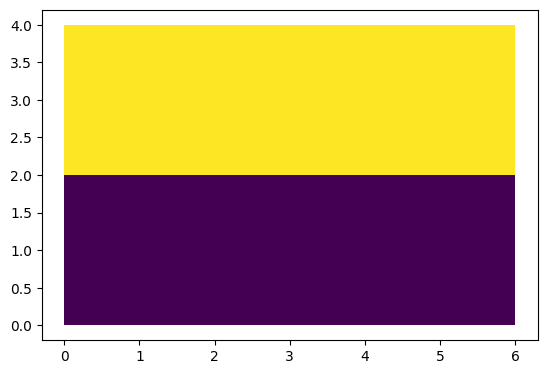

In [14]:
final_gdf.plot('pics')

## Generalização em funções

In [15]:
def minimum_intergeometry_boundaries_from_relations(
    df:pd.DataFrame|gpd.GeoDataFrame,
    df_id_col:str=None,
    other_id_col:str=None
) -> pd.DataFrame|gpd.GeoDataFrame:
    G = nx.from_pandas_edgelist(df[[df_id_col, other_id_col]], df_id_col, other_id_col)
    connected_components = list(nx.connected_components(G))
    rl_df = pd.DataFrame({'set': connected_components})
    rl_df = rl_df.reset_index()
    rl_df['index'] = rl_df['index'] + 1
    rl_df = rl_df.rename(columns={'index': 'pics'})
    rl_df = rl_df.explode('set')
    rl_df = rl_df.rename(columns={'set':'item'})
    rl_df = rl_df.reset_index(drop=True)
    return rl_df
    

In [16]:
def minimum_intergeometry_boundaries_from_geometries(df:gpd.GeoDataFrame, other:gpd.GeoDataFrame, df_id_col:str=None, other_id_col:str=None, buffer:float=0) -> gpd.GeoDataFrame:
    if df_id_col == None:
        df = df.reset_index().copy()
        df_id_col = df.columns[0]
    if other_id_col == None:
        other = other.reset_index().copy()
        other_id_col = other.columns[0]

    original_df_id_col = df_id_col
    original_other_id_col = other_id_col
    if df_id_col == other_id_col:
        original_df_id_col = df_id_col
        df_id_col = df_id_col + '_1'
        original_other_id_col = other_id_col
        other_id_col = other_id_col + '_2'
    adjusted_df = df.copy()
    if buffer != 0:
        adjusted_df['geometry'] = df.buffer(buffer)
    
    intersections = gpd.overlay(adjusted_df, other, how='intersection', keep_geom_type=True)
    return minimum_intergeometry_boundaries_from_relations(intersections, df_id_col, other_id_col)

In [17]:
def minimum_intergeometry_boundaries_geometries(
    geo_df:gpd.GeoDataFrame,
    rl_df:pd.DataFrame|gpd.GeoDataFrame,
    geo_df_id_col:str=None,
    rl_df_id_col:str=None,
) -> gpd.GeoDataFrame:
    if geo_df_id_col == None:
        geo_df = geo_df.reset_index().copy()
        geo_df_id_col = geo_df.columns[0]
    if rl_df_id_col == None:
        rl_df = rl_df.reset_index().copy()
        rl_df_id_col = other.columns[0]
    
    final_gdf = geo_df.merge(rl_df, how='left', left_on=geo_df_id_col, right_on=rl_df_id_col)
    final_gdf = final_gdf[['pics', 'geometry']].dissolve('pics')
    final_gdf = final_gdf.reset_index()
    return final_gdf

In [18]:
def minimum_intergeometry_boundaries(df:gpd.GeoDataFrame, other:gpd.GeoDataFrame, df_id_col:str=None, other_id_col:str=None, buffer:float=0) -> gpd.GeoDataFrame:
    original_df_id_col = df_id_col
    original_other_id_col = other_id_col
    rl_df = minimum_intergeometry_boundaries_from_geometries(df, other, df_id_col, other_id_col, buffer)
    
    final_gdf = minimum_intergeometry_boundaries_geometries(df, rl_df, original_df_id_col, 'item')
    return final_gdf

In [19]:
minimum_intergeometry_boundaries(gdf_a, gdf_b, 'id', 'id')

pics                                           geometry
0     1  POLYGON ((0.00000 0.00000, 0.00000 2.00000, 2....
1     2  POLYGON ((0.00000 2.00000, 6.00000 2.00000, 6....

<Axes: >

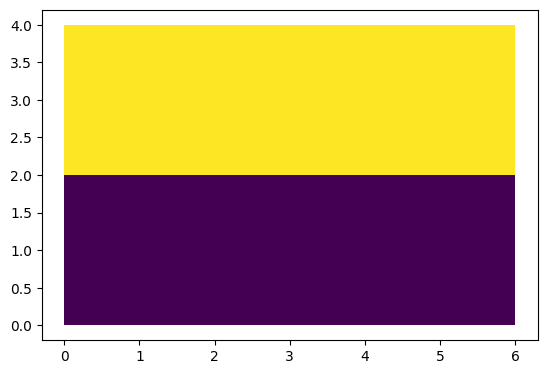

In [20]:
minimum_intergeometry_boundaries(gdf_a, gdf_b, 'id', 'id').plot(column='pics')

# Aplicando aos censos de 2010 e 2022

## Carregando os dados necessários

Para facilitar o desenvolvimento posterior, vamos concentrar os downloads e carregamentos iniciais nesta seção.

### Setores censitários de 2022

In [21]:
%%time
setores22 = download_malha(Censo.CENSO_2022, Nivel.SETORES)
setores22 = setores22[setores22['CD_MUN'] == '3550308']
setores22 = setores22.to_crs(epsg=31983)
setores22.sample(3)

CPU times: user 1min 3s, sys: 1.01 s, total: 1min 4s
Wall time: 1min 6s


CD_SETOR  AREA_KM2 CD_REGIAO NM_REGIAO CD_UF      NM_UF  \
75037  355030833000252P  0.072654         3   Sudeste    35  São Paulo   
79121  355030844000210P  0.004417         3   Sudeste    35  São Paulo   
70700  355030822000211P  0.015204         3   Sudeste    35  São Paulo   

        CD_MUN     NM_MUN    CD_DIST        NM_DIST  ... CD_CONCURB  \
75037  3550308  São Paulo  355030833       Iguatemi  ...    3550308   
79121  3550308  São Paulo  355030844  Jardim Helena  ...    3550308   
70700  3550308  São Paulo  355030822  Cidade Ademar  ...    3550308   

         NM_CONCURB v0001 v0002 v0003 v0004     v0005      v0006 v0007  \
75037  São Paulo/SP   851   411   411     0  2.985965  13.333333   285   
79121  São Paulo/SP    68    28    28     0  2.615385   7.692308    26   
70700  São Paulo/SP   395   157   157     0  2.687075   4.761905   147   

                                                geometry  
75037  POLYGON ((355305.883 7387223.039, 355288.133 7...  
79121  POLYGON ((354818.659 7401232.688, 354819.400 7...  
70700  POLYGON ((329354.752 7382447.238, 329341.710 7...  

[3 rows x 29 columns]

### Setores censitários de 2010

In [22]:
setores10 = download_malha(Censo.CENSO_2010, Nivel.SETORES)
setores10 = setores10[setores10['CD_GEOCODM'] == '3550308']
setores10 = setores10.to_crs(epsg=31983)
setores10.sample(3)

ID       CD_GEOCODI    TIPO   CD_GEOCODS NM_SUBDIST CD_GEOCODD  \
54191  119700.0  355030854000061  URBANO  35503085400       None  355030854   
44719  110301.0  355030812000002  URBANO  35503081200       None  355030812   
59598  125123.0  355030881000274   RURAL  35503088100       None  355030881   

      NM_DISTRIT CD_GEOCODM NM_MUNICIP   NM_MICRO                     NM_MESO  \
54191    MORUMBI    3550308  SÃO PAULO  SÃO PAULO  METROPOLITANA DE SÃO PAULO   
44719    BUTANTÃ    3550308  SÃO PAULO  SÃO PAULO  METROPOLITANA DE SÃO PAULO   
59598   TREMEMBÉ    3550308  SÃO PAULO  SÃO PAULO  METROPOLITANA DE SÃO PAULO   

      CD_GEOCODB NM_BAIRRO    ID1  \
54191       None      None  54192   
44719       None      None  44720   
59598       None      None  59599   

                                                geometry  
54191  POLYGON ((325868.338 7388018.509, 325935.821 7...  
44719  POLYGON ((322993.431 7391674.631, 322957.319 7...  
59598  POLYGON ((338355.661 7408961.593, 338362.052 7...

## Utilizando um distrito como exemplo

In [23]:
sample_dist = setores22['CD_DIST'].drop_duplicates().sample(1).iloc[0]
sample_dist

'355030816'

In [24]:
setores22_filtered = setores22[setores22['CD_DIST']==sample_dist].copy()
setores10_filtered = setores10[setores10['CD_GEOCODD']==sample_dist].copy()

Para mitigar possíveis problemas na definição dos setores censitários, vamos utilizar um buffer negativo de 10 metros.

In [25]:
pics_sample = minimum_intergeometry_boundaries(setores22_filtered, setores10_filtered, 'CD_SETOR', 'CD_GEOCODI', buffer=-10)
pics_sample

pics                                           geometry
0      1  POLYGON ((328673.510 7380666.575, 328682.455 7...
1      2  POLYGON ((329210.651 7380113.570, 329186.141 7...
2      3  POLYGON ((328880.464 7380257.426, 328857.691 7...
3      4  POLYGON ((328572.842 7380206.633, 328570.270 7...
4      5  POLYGON ((328631.371 7380052.706, 328529.201 7...
..   ...                                                ...
83    84  POLYGON ((328303.689 7382165.633, 328266.573 7...
84    85  POLYGON ((328024.390 7382016.357, 328008.687 7...
85    86  POLYGON ((329047.243 7378945.843, 329020.563 7...
86    87  POLYGON ((329546.951 7379452.865, 329530.433 7...
87    88  POLYGON ((329330.299 7380435.394, 329326.861 7...

[88 rows x 2 columns]

<Axes: >

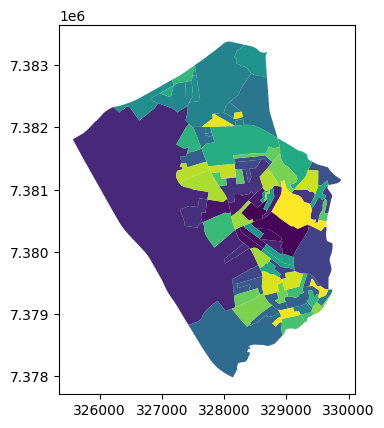

In [26]:
pics_sample.plot(column='pics')

Vamos comparar a quantidade de setores censitários nos anos de 2010 e 2022 e a quantidade de PICs gerados pelo algoritmo.

In [27]:
qtd10 = setores10_filtered.shape[0]
qtd22 = setores22_filtered.shape[0]
qtdpics_sample = pics_sample.shape[0]

pd.DataFrame({'Tabela': ['Censo 2010', 'Censo 2022', 'PICs'], 'Qtd geometrias': [qtd10, qtd22, qtdpics_sample]})

Tabela  Qtd geometrias
0  Censo 2010             178
1  Censo 2022             279
2        PICs              88

Nota-se que ocorre uma perda de granularidade considerável, mesmo em relação ao Censo mais antigo. De todo modo, ainda existe um quantidade razoável de geometrias dendro de um determinado distrito, enquanto se elimina o erro estatístico relacionado à interpolação.

## Aplicando a todo o município

In [28]:
relations = minimum_intergeometry_boundaries_from_geometries(setores22, setores10, 'CD_SETOR', 'CD_GEOCODI', buffer=-10)
relations

pics              item
0          1   355030801000001
1          1  355030801000001P
2          2  355030801000002P
3          2   355030801000002
4          3   355030801000003
...      ...               ...
46444  12319  355030896000312P
46445  12319   355030896000176
46446  12320   355030896000082
46447  12320  355030896000333P
46448  12320  355030896000334P

[46449 rows x 2 columns]

In [29]:
pics = minimum_intergeometry_boundaries(setores22, setores10, 'CD_SETOR', 'CD_GEOCODI', buffer=-10)
pics

pics                                           geometry
0          1.0  POLYGON ((339819.409 7392592.743, 339817.380 7...
1          2.0  POLYGON ((339965.618 7393034.241, 339934.552 7...
2          3.0  POLYGON ((340157.893 7392942.288, 340105.133 7...
3          4.0  POLYGON ((340045.666 7391770.990, 340009.197 7...
4          5.0  POLYGON ((339648.358 7392166.295, 339669.395 7...
...        ...                                                ...
12315  12316.0  POLYGON ((356196.012 7396633.098, 356191.317 7...
12316  12317.0  POLYGON ((358244.773 7397452.920, 358252.856 7...
12317  12318.0  POLYGON ((357889.446 7397072.666, 357886.447 7...
12318  12319.0  POLYGON ((354126.019 7397861.172, 354082.105 7...
12319  12320.0  POLYGON ((357493.635 7396053.355, 357440.784 7...

[12320 rows x 2 columns]

<Axes: >

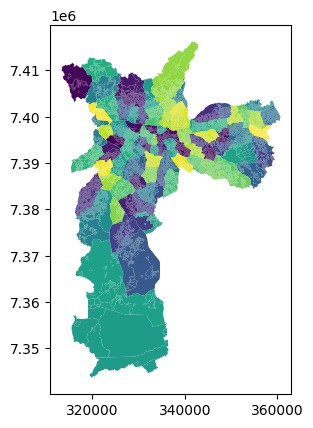

In [30]:
pics.plot(column='pics')

## Visualizando no mapa interativo

In [31]:
mapa_pics = setores10.explore(
    name='Setores (2010)',  # name of the layer in the map
    color='darkred',
    # style_kwds={'fill': False},
)
mapa_pics = setores22.explore(
    m=mapa_pics,
    name='Setores (2022)',  # name of the layer in the map
    color='royalblue',
    # style_kwds={'fill': False},
)
mapa_pics = pics.explore(
    m=mapa_pics,
    name='PICs',  # name of the layer in the map
    color='limegreen',
)

folium.LayerControl().add_to(mapa_pics)  # use folium to add layer control
# mapa_pics

In [32]:
mapa_pics.save('plots/Perímetros intercensitários.html')

# PICs pela tabela de relações do IBGE

Alternativamente, podemos construir os PICs a partir da tabela de comparabilidade fornecida pelo próprio IBGE, e apenas refinà-la com base nas geometrias.

In [33]:
rel_df_path = 'data/Comparabilidade - Setores Censitários 2022 - 2010.xlsx'
rel_df = pd.read_excel(rel_df_path, dtype={'SETOR_2022':str, 'SETOR_2010': str})
rel_df

SETOR_2022       SETOR_2010
0       130260305130134  130260305130057
1       130260305130147  130260305130046
2       130260305130156  130260305130088
3       130260305130180  130260305130009
4       130260305130188  130260305130081
...                 ...              ...
460655  520320305000020  520320305000011
460656  520320305000021  520320305000001
460657  520320305000023  520320305000003
460658  520330205000002  520330205000002
460659  520330205000012  520330205000012

[460660 rows x 2 columns]

In [34]:
rel_df = rel_df[rel_df['SETOR_2010'].str.startswith('3550308')].copy()
rel_df['SETOR_2022'] = rel_df['SETOR_2022'] + 'P'
rel_df

SETOR_2022       SETOR_2010
42455   355030812000159P  355030812000068
42456   355030814000066P  355030814000002
42457   355030815000282P  355030815000081
42458   355030815000294P  355030815000104
42459   355030815000295P  355030815000113
...                  ...              ...
449495  355030894000308P  355030894000192
449496  355030894000310P  355030894000114
449497  355030894000315P  355030894000260
449498  355030896000058P  355030896000058
449499  355030896000073P  355030896000073

[27899 rows x 2 columns]

## Sem ajustes

A princípio, vamos utilizar a tabela do IBGE na íntegra, sem nenhum ajuste, e avaliar os resultados

In [35]:
relations_2 = minimum_intergeometry_boundaries_from_relations(rel_df, 'SETOR_2022', 'SETOR_2010')
relations_2

pics              item
0          1   355030812000068
1          1  355030812000158P
2          1  355030812000159P
3          2  355030814000061P
4          2  355030814000063P
...      ...               ...
46540  18650  355030893000160P
46541  18651   355030896000058
46542  18651  355030896000058P
46543  18652   355030896000073
46544  18652  355030896000073P

[46545 rows x 2 columns]

In [36]:
pics_2 = minimum_intergeometry_boundaries_geometries(setores22, relations_2, 'CD_SETOR', 'item')
pics_2

pics                                           geometry
0          1  MULTIPOLYGON (((321955.398 7390903.098, 321953...
1          2  POLYGON ((335049.395 7393012.126, 335059.244 7...
2          3  POLYGON ((330942.859 7384618.325, 330935.849 7...
3          4  POLYGON ((330139.826 7385325.942, 330113.401 7...
4          5  POLYGON ((330140.914 7384689.826, 330145.998 7...
...      ...                                                ...
18647  18648  POLYGON ((340055.143 7401626.951, 339959.370 7...
18648  18649  POLYGON ((339740.591 7391062.687, 339642.891 7...
18649  18650  POLYGON ((340131.779 7390103.163, 340117.020 7...
18650  18651  POLYGON ((355764.386 7395773.121, 355759.043 7...
18651  18652  POLYGON ((355700.080 7397198.902, 355653.097 7...

[18652 rows x 2 columns]

<Axes: >

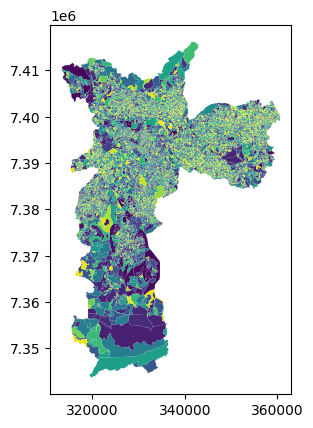

In [37]:
pics_2.plot(column='pics')

O resultado parece interessante. A granularidade ficou bastante próxima à do Censo de 2010, o que torna essa versão mais atrativa do que a construção dos PICs pelas geometrias.

Vamos avaliar se houve alguma anomalia com os polígonos descontínuos.

### Visualizando no mapa interativo

In [38]:
def create_map(
    gdf:gpd.GeoDataFrame,
    layer_name:str='',
    layer_color='limegreen',
    filter_tracts=True,
    filter_df:pd.DataFrame|gpd.GeoDataFrame=relations_2,
    save_path=None,
) -> folium.Map:
    if not filter_tracts:
        m = setores10.explore(
            name='Setores (2010)',  # name of the layer in the map
            color='darkred',
            # style_kwds={'fill': False},
        )
        m = setores22.explore(
            m=m,
            name='Setores (2022)',  # name of the layer in the map
            color='royalblue',
            # style_kwds={'fill': False},
        )
    else:
        tracts = filter_df.loc[filter_df['pics'].isin(gdf['pics']), 'item']
        m = setores10[setores10['CD_GEOCODI'].isin(tracts)].explore(
            name='Setores (2010)',  # name of the layer in the map
            color='darkred',
            # style_kwds={'fill': False},
        )
        m = setores22[setores22['CD_SETOR'].isin(tracts)].explore(
            m=m,
            name='Setores (2022)',  # name of the layer in the map
            color='royalblue',
            # style_kwds={'fill': False},
        )
        
    m = gdf.explore(
        m=m,
        name=layer_name,  # name of the layer in the map
        color=layer_color,
    )
    
    folium.LayerControl().add_to(m)  # use folium to add layer control
    
    if save_path != None:
        m.save(save_path)

    return m

In [39]:
pics_map = create_map(pics_2, 'PICs', filter_tracts=False, save_path='plots/Perímetros intercensitários - tabela IBGE.html')

In [40]:
multi_poly_pics = pics_2[pics_2.geom_type!='Polygon'].copy()

In [41]:
new_map = create_map(multi_poly_pics, 'PICs')
new_map

Algumas geometrias parecem fazer sentido, considerando as geometrias de 2022 envolvidas, mas outras deixam a impressão de que mais setores deveriam estar contidos na geometria.

Vamos avaliar também se existem polígonos de um mesmo PIC muito distantes entre si.

In [42]:
multi_poly_pics = multi_poly_pics.explode(index_parts=False)
multi_poly_pics

pics                                           geometry
0          1  POLYGON ((321955.398 7390903.098, 321953.339 7...
0          1  POLYGON ((321822.554 7391053.816, 321806.403 7...
24        25  POLYGON ((331520.028 7394038.388, 331485.012 7...
24        25  POLYGON ((331573.193 7394166.985, 331530.092 7...
30        31  POLYGON ((326301.688 7405949.235, 326298.262 7...
...      ...                                                ...
16608  16609  POLYGON ((330777.826 7395904.524, 330703.132 7...
16608  16609  POLYGON ((330796.177 7395973.162, 330721.409 7...
16608  16609  POLYGON ((330783.167 7396129.599, 330833.050 7...
17513  17514  POLYGON ((330636.552 7395618.803, 330660.273 7...
17513  17514  POLYGON ((330452.457 7395813.584, 330451.234 7...

[640 rows x 2 columns]

In [43]:
def calc_distance(row):
    return row['geometry'].distance(multi_poly_pics[multi_poly_pics['pics']==row['pics']].geometry).max()

multi_poly_pics['max_distance'] = multi_poly_pics.apply(calc_distance,axis=1)
multi_poly_pics

pics                                           geometry  max_distance
0          1  POLYGON ((321955.398 7390903.098, 321953.339 7...     63.589860
0          1  POLYGON ((321822.554 7391053.816, 321806.403 7...     63.589860
24        25  POLYGON ((331520.028 7394038.388, 331485.012 7...     26.537602
24        25  POLYGON ((331573.193 7394166.985, 331530.092 7...     26.537602
30        31  POLYGON ((326301.688 7405949.235, 326298.262 7...     64.841519
...      ...                                                ...           ...
16608  16609  POLYGON ((330777.826 7395904.524, 330703.132 7...    119.567531
16608  16609  POLYGON ((330796.177 7395973.162, 330721.409 7...    109.945471
16608  16609  POLYGON ((330783.167 7396129.599, 330833.050 7...    215.417285
17513  17514  POLYGON ((330636.552 7395618.803, 330660.273 7...    165.892695
17513  17514  POLYGON ((330452.457 7395813.584, 330451.234 7...    165.892695

[640 rows x 3 columns]

<Axes: >

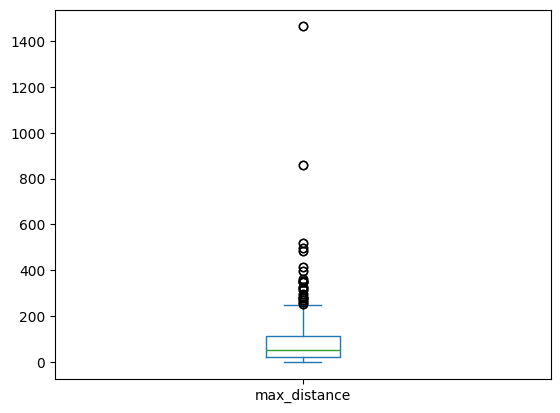

In [44]:
multi_poly_pics['max_distance'].plot.box()

De fato, existem polígonos muito distantes entre si. Vamos avaliar visualmente todos os outliers.

In [45]:
new_map = create_map(multi_poly_pics[multi_poly_pics['max_distance']> 300], 'PICs')
new_map

A inspeção visual, além de acender um alerta sobre uma possível relação desconexa ('35503086000041', '355030860000279'), acende também um alerta sobre a falta de uma relação provável ('355030860000157', '355030860000277P').

Vamos tentar novamente, desconsiderando as relações entre setores censitários que não possuem interseção entre suas geometrias.

## Considerando apenas interseções

In [46]:
rel_df = rel_df.merge(setores22[['CD_SETOR', 'geometry']], left_on='SETOR_2022', right_on='CD_SETOR')
rel_df = rel_df.drop(columns='CD_SETOR')
rel_df = rel_df.rename(columns={'geometry': 'geom22'})
rel_df

SETOR_2022       SETOR_2010  \
0      355030812000159P  355030812000068   
1      355030814000066P  355030814000002   
2      355030815000282P  355030815000081   
3      355030815000294P  355030815000104   
4      355030815000295P  355030815000113   
...                 ...              ...   
27894  355030894000308P  355030894000192   
27895  355030894000310P  355030894000114   
27896  355030894000315P  355030894000260   
27897  355030896000058P  355030896000058   
27898  355030896000073P  355030896000073   

                                                  geom22  
0      POLYGON ((321848.548 7391073.293, 321824.830 7...  
1      POLYGON ((335150.903 7392836.242, 335161.881 7...  
2      POLYGON ((330900.419 7384631.733, 330917.716 7...  
3      POLYGON ((330139.826 7385325.942, 330037.035 7...  
4      POLYGON ((330145.998 7384685.613, 330140.914 7...  
...                                                  ...  
27894  POLYGON ((322342.923 7387647.277, 322326.381 7...  
27895  POLYGON ((322545.945 7389551.045, 322539.847 7...  
27896  POLYGON ((321731.150 7387361.612, 321695.094 7...  
27897  POLYGON ((355764.386 7395773.121, 355759.043 7...  
27898  POLYGON ((355700.080 7397198.902, 355653.097 7...  

[27899 rows x 3 columns]

In [47]:
rel_df = rel_df.merge(setores10[['CD_GEOCODI', 'geometry']], left_on='SETOR_2010', right_on='CD_GEOCODI')
rel_df = rel_df.drop(columns='CD_GEOCODI')
rel_df = rel_df.rename(columns={'geometry': 'geom10'})
rel_df

SETOR_2022       SETOR_2010  \
0      355030812000159P  355030812000068   
1      355030814000066P  355030814000002   
2      355030815000282P  355030815000081   
3      355030815000294P  355030815000104   
4      355030815000295P  355030815000113   
...                 ...              ...   
27894  355030894000308P  355030894000192   
27895  355030894000310P  355030894000114   
27896  355030894000315P  355030894000260   
27897  355030896000058P  355030896000058   
27898  355030896000073P  355030896000073   

                                                  geom22  \
0      POLYGON ((321848.548 7391073.293, 321824.830 7...   
1      POLYGON ((335150.903 7392836.242, 335161.881 7...   
2      POLYGON ((330900.419 7384631.733, 330917.716 7...   
3      POLYGON ((330139.826 7385325.942, 330037.035 7...   
4      POLYGON ((330145.998 7384685.613, 330140.914 7...   
...                                                  ...   
27894  POLYGON ((322342.923 7387647.277, 322326.381 7...   
27895  POLYGON ((322545.945 7389551.045, 322539.847 7...   
27896  POLYGON ((321731.150 7387361.612, 321695.094 7...   
27897  POLYGON ((355764.386 7395773.121, 355759.043 7...   
27898  POLYGON ((355700.080 7397198.902, 355653.097 7...   

                                                  geom10  
0      POLYGON ((321858.681 7391132.742, 321880.349 7...  
1      POLYGON ((335049.395 7393012.126, 335059.244 7...  
2      POLYGON ((330812.207 7384774.836, 330816.975 7...  
3      POLYGON ((329988.847 7385276.059, 329887.217 7...  
4      POLYGON ((329780.707 7384872.361, 329788.170 7...  
...                                                  ...  
27894  POLYGON ((322150.627 7387606.500, 322177.819 7...  
27895  POLYGON ((322520.094 7389578.421, 322539.847 7...  
27896  POLYGON ((321498.115 7387509.259, 321497.938 7...  
27897  POLYGON ((355769.881 7395741.461, 355735.335 7...  
27898  POLYGON ((355448.661 7397398.193, 355471.393 7...  

[27899 rows x 4 columns]

In [48]:
rel_df = gpd.GeoDataFrame(rel_df)
rel_df

SETOR_2022       SETOR_2010  \
0      355030812000159P  355030812000068   
1      355030814000066P  355030814000002   
2      355030815000282P  355030815000081   
3      355030815000294P  355030815000104   
4      355030815000295P  355030815000113   
...                 ...              ...   
27894  355030894000308P  355030894000192   
27895  355030894000310P  355030894000114   
27896  355030894000315P  355030894000260   
27897  355030896000058P  355030896000058   
27898  355030896000073P  355030896000073   

                                                  geom22  \
0      POLYGON ((321848.548 7391073.293, 321824.830 7...   
1      POLYGON ((335150.903 7392836.242, 335161.881 7...   
2      POLYGON ((330900.419 7384631.733, 330917.716 7...   
3      POLYGON ((330139.826 7385325.942, 330037.035 7...   
4      POLYGON ((330145.998 7384685.613, 330140.914 7...   
...                                                  ...   
27894  POLYGON ((322342.923 7387647.277, 322326.381 7...   
27895  POLYGON ((322545.945 7389551.045, 322539.847 7...   
27896  POLYGON ((321731.150 7387361.612, 321695.094 7...   
27897  POLYGON ((355764.386 7395773.121, 355759.043 7...   
27898  POLYGON ((355700.080 7397198.902, 355653.097 7...   

                                                  geom10  
0      POLYGON ((321858.681 7391132.742, 321880.349 7...  
1      POLYGON ((335049.395 7393012.126, 335059.244 7...  
2      POLYGON ((330812.207 7384774.836, 330816.975 7...  
3      POLYGON ((329988.847 7385276.059, 329887.217 7...  
4      POLYGON ((329780.707 7384872.361, 329788.170 7...  
...                                                  ...  
27894  POLYGON ((322150.627 7387606.500, 322177.819 7...  
27895  POLYGON ((322520.094 7389578.421, 322539.847 7...  
27896  POLYGON ((321498.115 7387509.259, 321497.938 7...  
27897  POLYGON ((355769.881 7395741.461, 355735.335 7...  
27898  POLYGON ((355448.661 7397398.193, 355471.393 7...  

[27899 rows x 4 columns]

In [49]:
type(rel_df['geom10'])

geopandas.geoseries.GeoSeries

In [50]:
rel_df['intersects'] = rel_df['geom22'].intersects(rel_df['geom10'])
rel_df

SETOR_2022       SETOR_2010  \
0      355030812000159P  355030812000068   
1      355030814000066P  355030814000002   
2      355030815000282P  355030815000081   
3      355030815000294P  355030815000104   
4      355030815000295P  355030815000113   
...                 ...              ...   
27894  355030894000308P  355030894000192   
27895  355030894000310P  355030894000114   
27896  355030894000315P  355030894000260   
27897  355030896000058P  355030896000058   
27898  355030896000073P  355030896000073   

                                                  geom22  \
0      POLYGON ((321848.548 7391073.293, 321824.830 7...   
1      POLYGON ((335150.903 7392836.242, 335161.881 7...   
2      POLYGON ((330900.419 7384631.733, 330917.716 7...   
3      POLYGON ((330139.826 7385325.942, 330037.035 7...   
4      POLYGON ((330145.998 7384685.613, 330140.914 7...   
...                                                  ...   
27894  POLYGON ((322342.923 7387647.277, 322326.381 7...   
27895  POLYGON ((322545.945 7389551.045, 322539.847 7...   
27896  POLYGON ((321731.150 7387361.612, 321695.094 7...   
27897  POLYGON ((355764.386 7395773.121, 355759.043 7...   
27898  POLYGON ((355700.080 7397198.902, 355653.097 7...   

                                                  geom10  intersects  
0      POLYGON ((321858.681 7391132.742, 321880.349 7...        True  
1      POLYGON ((335049.395 7393012.126, 335059.244 7...        True  
2      POLYGON ((330812.207 7384774.836, 330816.975 7...        True  
3      POLYGON ((329988.847 7385276.059, 329887.217 7...        True  
4      POLYGON ((329780.707 7384872.361, 329788.170 7...        True  
...                                                  ...         ...  
27894  POLYGON ((322150.627 7387606.500, 322177.819 7...        True  
27895  POLYGON ((322520.094 7389578.421, 322539.847 7...        True  
27896  POLYGON ((321498.115 7387509.259, 321497.938 7...        True  
27897  POLYGON ((355769.881 7395741.461, 355735.335 7...        True  
27898  POLYGON ((355448.661 7397398.193, 355471.393 7...        True  

[27899 rows x 5 columns]

In [51]:
rel_df['intersects'].value_counts()

intersects
True     27242
False      657
Name: count, dtype: int64

Como se esperava, a tabela contém relações entre setores que não se conectam geograficamente. Primeiro, vamos avaliar se todos os setores possuem relações conectadas geograficamente.

In [52]:
rel_df[rel_df['intersects']==True]['SETOR_2022'].drop_duplicates().shape

(26941,)

In [53]:
setores22.shape

(27592, 29)

In [54]:
27592-26941

651

In [55]:
rel_df[rel_df['intersects']==True]['SETOR_2010'].drop_duplicates().shape

(18567,)

In [56]:
setores10.shape

(18953, 15)

In [57]:
18953-18567

386

De fato, desconsiderar as relações sem conexão geográfica leva à exclusão de aproximadamente 2% dos setores de cada Censo, o que, apesar de ser um percentual pequeno, acaba inviabilizando a técnica por gerar uma malha descontínua para o município.

O caminho para a solução desse problema parece ser utilizar as relações fornecidas pelo IBGE para os setores que possuem interseção e adicionar as relações baseadas nas geometrias para os setores excluídos.

In [58]:
rel_df2 = rel_df[rel_df['intersects']==True][['SETOR_2022', 'SETOR_2010']].copy()

In [59]:
excluded_22 = rel_df[rel_df['intersects']==False][['SETOR_2022']].drop_duplicates()
excluded_22 = excluded_22[~excluded_22['SETOR_2022'].isin(rel_df2['SETOR_2022'])]
excluded_22

SETOR_2022
8      355030817000044P
75     355030806000068P
84     355030811000041P
91     355030816000080P
93     355030802000154P
...                 ...
27725  355030888000064P
27744  355030895000190P
27753  355030886000125P
27766  355030894000155P
27777  355030888000121P

[651 rows x 1 columns]

In [60]:
excluded_22 = setores22[setores22['CD_SETOR'].isin(excluded_22['SETOR_2022'])][['CD_SETOR', 'geometry']].copy()
excluded_22['geometry'] = excluded_22.buffer(-3)
excluded_22

CD_SETOR                                           geometry
65967  355030802000077P  POLYGON ((324467.675 7395941.930, 324468.799 7...
66010  355030802000120P  POLYGON ((324461.971 7394632.710, 324461.726 7...
66044  355030802000154P  POLYGON ((324619.431 7395271.898, 324619.568 7...
66046  355030802000156P  POLYGON ((324626.186 7395335.743, 324626.279 7...
66048  355030802000158P  POLYGON ((324725.745 7395354.932, 324696.204 7...
...                 ...                                                ...
92807  355030894000331P  POLYGON ((320762.808 7389760.375, 320762.595 7...
92808  355030894000332P  POLYGON ((320767.136 7389755.730, 320767.192 7...
92821  355030894000345P  POLYGON ((321304.851 7389474.611, 321333.019 7...
92969  355030895000190P  POLYGON ((321728.147 7399438.889, 321701.572 7...
93180  355030896000152P  POLYGON ((354258.956 7397461.243, 354265.714 7...

[651 rows x 2 columns]

In [61]:
exc_rel = gpd.overlay(excluded_22, setores10[['CD_GEOCODI', 'geometry']], how='intersection', keep_geom_type=True)
exc_rel = exc_rel.rename(columns={'CD_SETOR': 'SETOR_2022', 'CD_GEOCODI': 'SETOR_2010'})
exc_rel

SETOR_2022       SETOR_2010  \
0     355030802000077P  355030802000062   
1     355030802000077P  355030802000063   
2     355030802000120P  355030802000043   
3     355030802000154P  355030802000018   
4     355030802000156P  355030802000018   
...                ...              ...   
1101  355030894000345P  355030894000156   
1102  355030895000190P  355030895000027   
1103  355030896000152P  355030896000153   
1104  355030896000152P  355030896000154   
1105  355030896000152P  355030896000229   

                                               geometry  
0     POLYGON ((324462.928 7395854.773, 324463.210 7...  
1     POLYGON ((324468.799 7395941.752, 324469.035 7...  
2     POLYGON ((324461.726 7394632.299, 324461.668 7...  
3     POLYGON ((324619.568 7395271.794, 324619.847 7...  
4     POLYGON ((324626.279 7395311.290, 324626.294 7...  
...                                                 ...  
1101  POLYGON ((321385.156 7389478.559, 321385.208 7...  
1102  POLYGON ((321701.572 7399450.858, 321719.663 7...  
1103  POLYGON ((354217.339 7397369.162, 354217.211 7...  
1104  POLYGON ((354216.974 7397442.119, 354216.844 7...  
1105  POLYGON ((354265.714 7397436.045, 354266.722 7...  

[1106 rows x 3 columns]

In [62]:
rel_df2 = pd.concat([rel_df2, exc_rel[['SETOR_2022', 'SETOR_2010']]])
rel_df2

SETOR_2022       SETOR_2010
0     355030812000159P  355030812000068
1     355030814000066P  355030814000002
2     355030815000282P  355030815000081
3     355030815000294P  355030815000104
4     355030815000295P  355030815000113
...                ...              ...
1101  355030894000345P  355030894000156
1102  355030895000190P  355030895000027
1103  355030896000152P  355030896000153
1104  355030896000152P  355030896000154
1105  355030896000152P  355030896000229

[28348 rows x 2 columns]

Vamos checar se todos os setores estão presentes e, caso não, realizar o mesmo procedimento para os setores censitários faltantes.

In [63]:
rel_df2['SETOR_2022'].drop_duplicates()

0       355030812000159P
1       355030814000066P
2       355030815000282P
3       355030815000294P
4       355030815000295P
              ...       
1095    355030894000331P
1098    355030894000332P
1100    355030894000345P
1102    355030895000190P
1103    355030896000152P
Name: SETOR_2022, Length: 27592, dtype: object

In [64]:
rel_df2['SETOR_2010'].drop_duplicates()

0       355030812000068
1       355030814000002
2       355030815000081
3       355030815000104
4       355030815000113
             ...       
1076    355030894000155
1083    355030894000194
1085    355030894000195
1087    355030894000193
1094    355030894000204
Name: SETOR_2010, Length: 18690, dtype: object

In [65]:
18953-18681

272

Ainda faltam 272 setores censitários de 2010, então vamos utilizar a versão baseada na geometria para esses setores.

In [66]:
excluded_10 = rel_df[rel_df['intersects']==False][['SETOR_2010']].drop_duplicates()
excluded_10 = excluded_10[~excluded_10['SETOR_2010'].isin(rel_df2['SETOR_2010'])]
excluded_10

SETOR_2010
8      355030817000044
75     355030806000031
91     355030816000080
99     355030806000033
155    355030816000119
...                ...
26951  355030883000137
27202  355030871000127
27259  355030880000156
27302  355030882000153
27335  355030882000172

[263 rows x 1 columns]

In [67]:
excluded_10 = setores10[setores10['CD_GEOCODI'].isin(excluded_10['SETOR_2010'])][['CD_GEOCODI', 'geometry']].copy()
excluded_10['geometry'] = excluded_10.buffer(-3)
excluded_10

CD_GEOCODI                                           geometry
43552  355030802000023  POLYGON ((324533.566 7395664.040, 324580.054 7...
43606  355030802000077  POLYGON ((324492.381 7396036.378, 324493.915 7...
43871  355030805000031  POLYGON ((348734.779 7395433.949, 348708.491 7...
43957  355030805000117  POLYGON ((348530.334 7394846.996, 348569.812 7...
44021  355030806000031  POLYGON ((327187.122 7398789.205, 327221.315 7...
...                ...                                                ...
61914  355030894000143  POLYGON ((321663.985 7388457.567, 321659.953 7...
61925  355030894000154  POLYGON ((321066.934 7390388.858, 321131.842 7...
61944  355030894000173  POLYGON ((323686.130 7388278.220, 323693.075 7...
62002  355030894000245  POLYGON ((323974.533 7389264.210, 323938.120 7...
62289  355030896000152  POLYGON ((354174.821 7397273.943, 354166.675 7...

[263 rows x 2 columns]

In [68]:
exc_rel = gpd.overlay(excluded_10, setores22[['CD_SETOR', 'geometry']], how='intersection', keep_geom_type=True)
exc_rel = exc_rel.rename(columns={'CD_SETOR': 'SETOR_2022', 'CD_GEOCODI': 'SETOR_2010'})
exc_rel

SETOR_2010        SETOR_2022  \
0    355030802000023  355030802000098P   
1    355030802000077  355030802000063P   
2    355030805000031  355030805000030P   
3    355030805000117  355030805000116P   
4    355030806000031  355030806000064P   
..               ...               ...   
337  355030894000154  355030894000153P   
338  355030894000173  355030894000295P   
339  355030894000245  355030894000247P   
340  355030896000152  355030896000229P   
341  355030896000152  355030896000230P   

                                              geometry  
0    POLYGON ((324580.054 7395664.008, 324580.044 7...  
1    POLYGON ((324493.915 7396037.615, 324507.021 7...  
2    POLYGON ((348708.491 7395419.791, 348690.808 7...  
3    POLYGON ((348569.812 7394844.128, 348575.858 7...  
4    POLYGON ((327221.315 7398804.038, 327242.070 7...  
..                                                 ...  
337  POLYGON ((321131.842 7390390.262, 321134.897 7...  
338  POLYGON ((323693.075 7388344.539, 323721.389 7...  
339  POLYGON ((323938.120 7389278.602, 323959.389 7...  
340  POLYGON ((354166.675 7397290.300, 354145.790 7...  
341  POLYGON ((354221.315 7397268.575, 354220.773 7...  

[342 rows x 3 columns]

In [69]:
rel_df2 = pd.concat([rel_df2, exc_rel[['SETOR_2022', 'SETOR_2010']]])
rel_df2

SETOR_2022       SETOR_2010
0    355030812000159P  355030812000068
1    355030814000066P  355030814000002
2    355030815000282P  355030815000081
3    355030815000294P  355030815000104
4    355030815000295P  355030815000113
..                ...              ...
337  355030894000153P  355030894000154
338  355030894000295P  355030894000173
339  355030894000247P  355030894000245
340  355030896000229P  355030896000152
341  355030896000230P  355030896000152

[28690 rows x 2 columns]

Vamos checar novamente se todos os setores estão presentes e, caso não, realizar o mesmo procedimento para os setores censitários faltantes.

In [70]:
rel_df2['SETOR_2022'].drop_duplicates()

0       355030812000159P
1       355030814000066P
2       355030815000282P
3       355030815000294P
4       355030815000295P
              ...       
1095    355030894000331P
1098    355030894000332P
1100    355030894000345P
1102    355030895000190P
1103    355030896000152P
Name: SETOR_2022, Length: 27592, dtype: object

In [71]:
rel_df2['SETOR_2010'].drop_duplicates()

0      355030812000068
1      355030814000002
2      355030815000081
3      355030815000104
4      355030815000113
            ...       
335    355030894000143
336    355030894000154
338    355030894000173
339    355030894000245
340    355030896000152
Name: SETOR_2010, Length: 18953, dtype: object

Todos os setores estão presentes, então vamos gerar os PICs pelas relações encontradas.

In [72]:
relations_3 = minimum_intergeometry_boundaries_from_relations(rel_df2, 'SETOR_2022', 'SETOR_2010')
relations_3

pics              item
0          1   355030812000138
1          1  355030812000141P
2          1  355030812000140P
3          1  355030812000138P
4          1  355030812000142P
...      ...               ...
46540  18013  355030859000193P
46541  18014  355030865000165P
46542  18014   355030865000163
46543  18015   355030888000064
46544  18015  355030888000143P

[46545 rows x 2 columns]

In [73]:
pics_3 = minimum_intergeometry_boundaries_geometries(setores22, relations_3, 'CD_SETOR', 'item')
pics_3

pics                                           geometry
0          1  POLYGON ((321950.584 7390879.337, 321943.473 7...
1          2  POLYGON ((335049.395 7393012.126, 335059.244 7...
2          3  POLYGON ((330942.859 7384618.325, 330935.849 7...
3          4  POLYGON ((330139.826 7385325.942, 330113.401 7...
4          5  POLYGON ((330140.914 7384689.826, 330145.998 7...
...      ...                                                ...
18010  18011  POLYGON ((355700.080 7397198.902, 355653.097 7...
18011  18012  POLYGON ((328275.792 7382329.016, 328267.827 7...
18012  18013  POLYGON ((343815.475 7397633.488, 343819.715 7...
18013  18014  POLYGON ((319851.360 7390427.956, 319822.778 7...
18014  18015  POLYGON ((323396.815 7396912.097, 323393.007 7...

[18015 rows x 2 columns]

<Axes: >

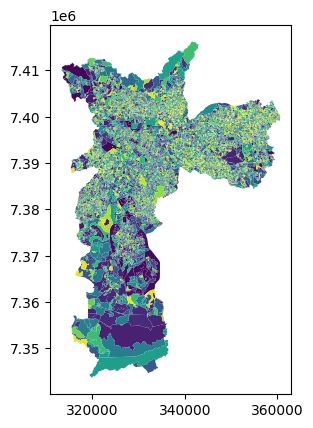

In [74]:
pics_3.plot(column='pics')

Aparentemente o método apresenta boa granularidade e considerar apenas as relações declaradas que apresentam interseção entre as geometrias corrige eventuais relações incorretas. Vamos avaliar interativamente um distrito aleatório.

### Visualizando no mapa interativo

In [75]:
sample_pics = relations_3.loc[relations_3['item'].isin(setores22_filtered['CD_SETOR']), 'pics'].to_list()
sample_pics[:10]

[61, 62, 63, 84, 108, 108, 108, 108, 108, 108]

In [76]:
create_map(pics_3[pics_3['pics'].isin(sample_pics)], 'PICs', filter_tracts=True, filter_df=relations_3)#, save_path='plots/Perímetros intercensitários - tabela IBGE.html')

O resultado parece, de fato, muito mais satisfatório do que se basear apenas nas geometrias para a obtenção dos perímetros intercensitários. De todo modo, falta realizar os cálculos das variáveis para cada perímetro intercensitário e avaliar o resultado final dessas geometrias.

In [77]:
pics3_map = create_map(pics_3, 'PICs', filter_tracts=False, save_path='plots/Perímetros intercensitários - híbrido.html')